In [1]:
# %pip install opencv-python
# %pip install opencv-contrib-python


In [5]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt


In [3]:
path = "Dataset_projet_pretraitement_textes_images\Flipkart\Images"
image_paths = glob.glob(os.path.join(path, "*.jpg"))  # prend .jpg, .jpeg, .png
output_path = "Dataset_projet_pretraitement_textes_images\Flipkart\Preprocessed_Images"

print(f"{len(image_paths)} images trouvées")


1050 images trouvées


In [4]:
img_treated = []
for img_path in image_paths:
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (256, 256)) #pour mettre toutes les images à la même taille
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #on passe en niveaux de gris
        eq = cv2.equalizeHist(gray) #on augmente le contraste pour faire ressortir les texture sur les images
        img_treated.append(eq)

img_treated = np.array(img_treated)
print(img_treated.shape)

(1050, 256, 256)


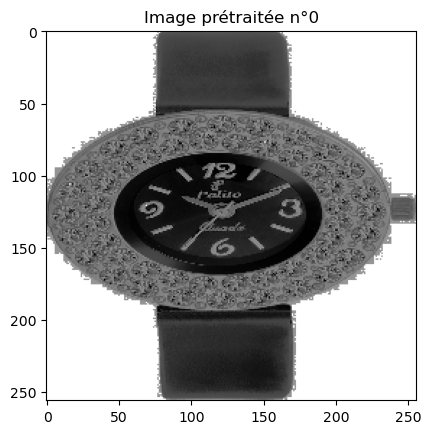

In [ ]:
#Pour vérifier mon traitement d'image

plt.imshow(img_treated[0].reshape(256, 256), cmap='gray')
plt.title("Image prétraitée n°0")
plt.show()